In [1]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

# custom classes and functions
import models
from models.blocks import ConvBlock, TransposeConvBlock, ResConvBlock, CategoricalStraightThrough
from models.mlp import MLP
from models.autoencoder import Autoencoder
from models.vae import VAE
from models.categorical_vae import CategoricalVAE
from models.sequential_categorical_vae import SeqCatVAE
from preprocessing import grayscale_transform as transform

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Set Hyperparameters

In [3]:
batch_size = 8

A = 3 # number of action dimensions (3 for toy, 2 for real sim)
H = 512 # discrete h state 
Z = 32*32 # stochastic Zx1 state

## RSSM

In [4]:
class RSSM(nn.Module):
    def __init__(self):
        super(RSSM, self).__init__()
        
        # init the VAE
        self.vae = SeqCatVAE(H, Z, grayscale=True, vae_ent_coeff=1e-8)
        
        # init the RNN
        self.num_rnn_layers = 1
        self.rnn = nn.GRU(input_size=A+H+Z, hidden_size=H, num_layers=self.num_rnn_layers)
        
        # init MLPs
        self.dynamics_mlp = MLP(input_dims=H, output_dims=Z) # H -> Z
        self.reward_mlp = MLP(input_dims=H+Z, output_dims=1) # state (H+Z) -> 1
        self.continue_mlp = MLP(input_dims=H+Z, output_dims=1) # state (H+Z)->1 # add sigmoid and BinaryCE  
    
    def step(self, action, h, z):

        # concatenate the rnn_input and apply RNN to obtain the next hidden state
        rnn_input = torch.cat((action, h.view(-1, H), z), 1)
        _, h = self.rnn(rnn_input, h.view(-1, H))
        
        state = torch.cat((h.view(-1, H), z), 1)
        
        # predict the reward and continue flag
        reward_pred = rssm.reward_mlp(state)
        continue_prob = torch.sigmoid(rssm.continue_mlp(state)) # binary classification
        continue_pred = bool(continue_prob > 0.5)
        
        x_reconstruction = rssm.vae.decode(h, z)
        
        return h, reward_pred, continue_prob, continue_pred, x_reconstruction
    
    def calculate_loss(self,
                       x_target, x_pred, 
                       reward_target, reward_pred, 
                       continue_target, continue_prob, 
                       z_prior, z_posterior):
        
        image_loss = F.mse_loss(x_target, x_pred, reduction="mean")
        reward_loss = F.mse_loss(reward_target.squeeze(), reward_pred.squeeze(), reduction="mean")
        continue_loss = F.binary_cross_entropy(continue_prob.squeeze(), continue_target.squeeze())
        loss = image_loss + reward_loss + continue_loss
        
        return loss, image_loss, reward_loss, continue_loss
    
    # def info(self):
    # - look at VAE.info() 
    
    # def print_num_params(self):
    #     print(f"RSSM ==> number of parameters: {sum(p.numel() for p in rssm.parameters() if p.requires_grad):_}")

In [5]:
rssm = RSSM().to(device)

rssm_optim = optim.Adam(
    rssm.parameters(), 
    lr=1e-3,
    weight_decay=1e-5 # l2 regularization
)

In [6]:
value_net = MLP(input_dims=Z, output_dims=1).to(device) # state (H+Z) -> 1
policy_net = MLP(input_dims=Z, output_dims=A).to(device) # state (H+Z) -> A

## Training loop

In [7]:
""" vae training loop """

# create the environment
toy_env = True

if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=50, render_mode="rgb_array") # rgb_array/human
else:
    assert A==2
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

verbose = True
n_episodes = 300
losses, image_losses, reward_losses, continue_losses  = [], [], [], []
rssm.train()

for episode in tqdm(range(n_episodes)): # tqdm
    
    # get the initial state
    obs, info = env.reset()
    
    # reset the rnn's hidden state
    h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H
    
    # setup a minibatch of x's for training the autoencoder
    # batch_counter = 0
    # batch_tensor = torch.empty((batch_size,) + transform(obs).shape, device=device) # B,C,H,W
    
    episode_length = 0
    episode_loss = torch.tensor(0, device=device, dtype=torch.float32)
    episode_image_loss = torch.tensor(0, device=device, dtype=torch.float32)
    episode_reward_loss = torch.tensor(0, device=device, dtype=torch.float32)
    episode_continue_loss = torch.tensor(0, device=device, dtype=torch.float32)
    
    # play one episode
    done = False
    while not done:
        
        x = transform(obs).view(-1, 1, 128, 128)
        
        """ WORLD MODEL LEARNING """
        
        # predict z and generate the true stochastic latent variable z with the encoder
        z_pred = rssm.dynamics_mlp(h).view(-1, Z) # B,1024 (flattened)
        z = rssm.vae.encode(h, x).view(-1, Z) # TODO: use h,x
        
        # apply external actor and critic nets on z
        action = policy_net(z) # a is a 2x1 vector
        v = value_net(z)
        
        # predict one step using the RSSM and apply the actor-critic
        h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)
        
        # choose and execute an action
        next_obs, reward, terminated, truncated, info = env.step(action.squeeze().detach().cpu().numpy())        
               
        done = terminated or truncated
        obs = next_obs
        
        # calculate the loss
        continue_target = torch.tensor(1 - done, device=device, dtype=torch.float32)
        reward = torch.tensor(reward, device=device, dtype=torch.float32)

        # TODO: z_prior, z_posterior
        z_prior = torch.tensor(0, device=device, dtype=torch.float32)
        z_posterior = torch.tensor(0, device=device, dtype=torch.float32)

        loss, image_loss, reward_loss, continue_loss = rssm.calculate_loss(
            x, x_pred, reward, reward_pred, continue_target, continue_prob, z_prior, z_posterior)
        
        episode_length += 1
        episode_loss += loss
        episode_image_loss += image_loss
        episode_reward_loss += reward_loss
        episode_continue_loss += continue_loss
    
    # calculate the mean loss of the episode
    episode_loss /= episode_length
    episode_image_loss /= episode_length
    episode_reward_loss /= episode_length
    episode_continue_loss /= episode_length
    
    # update the world model at the end of an episode using the mean loss of the episode
    rssm_optim.zero_grad()
    episode_loss.backward() # retain_graph=True
    rssm_optim.step()
    
    # log the mean episode losses
    losses.append(episode_loss.item())
    image_losses.append(episode_image_loss.item())
    reward_losses.append(episode_reward_loss.item())
    continue_losses.append(episode_continue_loss.item())
    
    # if verbose: 
    #     print(f"train episode [{episode}/{n_episodes}] ===> Loss: {vae_loss.item():.3f}, ReconstructionLoss: {reconstruction_loss.item():.3f}, weighted_entropy_loss: {weighted_entropy_loss.item():.3f}")
        
env.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:32<00:00,  1.71s/it]


In [8]:
# 10 steps -> 6504MiB
# 50 steps -> 19990MiB

In [9]:
# H+Z -> H+Z+A
# maybe rnn is the problem.

# solution: you need a batch for the entire sequence and can only backprop once at the end. 
# this would match with the paper.

## Plot results

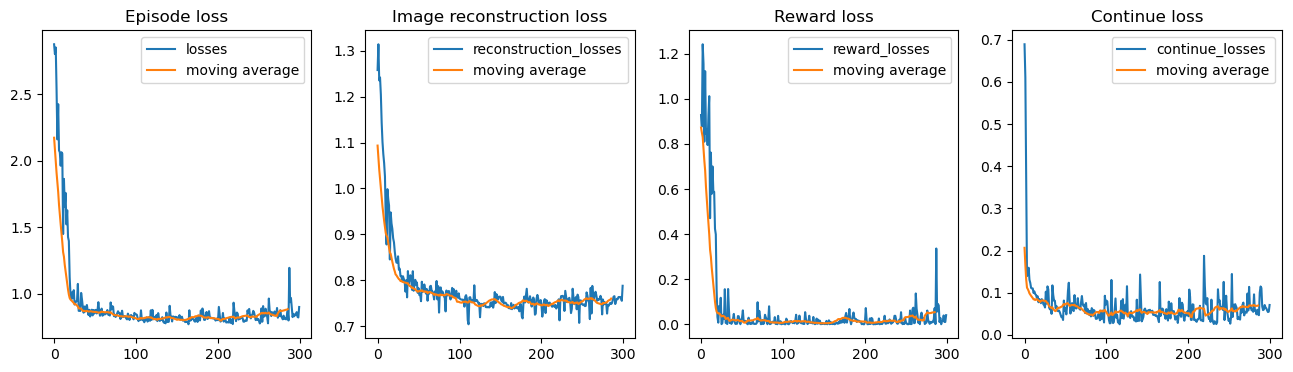

In [88]:
rolling_length = max(1, int(len(losses)/20))

fig, axs = plt.subplots(ncols=4, figsize=(4*4, 4))

# Episode loss
axs[0].set_title("Episode loss")
losses_moving_average = (
    np.convolve(
        np.array(losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(losses)), losses, label="losses")
axs[0].plot(range(len(losses_moving_average)), losses_moving_average, label="moving average")
axs[0].legend(loc="upper right")

# Image reconstruction loss
axs[1].set_title("Image reconstruction loss")
image_losses_moving_average = (
    np.convolve(
        np.array(image_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(image_losses)), image_losses, label="reconstruction_losses")
axs[1].plot(range(len(image_losses_moving_average)), image_losses_moving_average, label="moving average")
axs[1].legend(loc="upper right")

# Reward loss
axs[2].set_title("Reward loss")
reward_losses_moving_average = (
    np.convolve(
        np.array(reward_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(reward_losses)), reward_losses, label="reward_losses")
axs[2].plot(range(len(reward_losses_moving_average)), reward_losses_moving_average, label="moving average")
axs[2].legend(loc="upper right");

# Continue loss
axs[3].set_title("Continue loss")
continue_losses_moving_average = (
    np.convolve(
        np.array(continue_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[3].plot(range(len(continue_losses)), continue_losses, label="continue_losses")
axs[3].plot(range(len(continue_losses_moving_average)), continue_losses_moving_average, label="moving average")
axs[3].legend(loc="upper right");

# Overfitting and visualization playground

In [11]:
""" overfit to one sample to test whether the VAE works """
overfit = False

if overfit:
    batch_tensor = torch.load("batch_tensor.pt").to(device)
    vae_losses, reconstruction_losses, entropy_losses = [], [], []
    
    for i in range(200):
        
        xhat = vae(batch_tensor)
    
        # get a loss and update the autoencoder
        vae_loss, reconstruction_loss, entropy_loss = vae.get_loss(batch_tensor, xhat)
        vae_optim.zero_grad()
        vae_loss.backward()
        vae_optim.step()
    
        vae_losses.append(vae_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        entropy_losses.append(entropy_loss.item())
    
        if i % 20 == 0:
            print(f"[{i+1}/{200}] loss: {vae_loss.item()}, entropy loss: {entropy_loss}, lr: {get_lr(vae_optim)}")

In [87]:
visualize = False

if visualize:
    if toy_env:
        x = torch.load("batch_tensor_toy.pt").to(device)
        h = torch.load("h_tensor.pt").to(device)
    else:
        x = torch.load("batch_tensor.pt")[0].unsqueeze(dim=0).to(device)
        h = torch.load("h_tensor.pt").to(device)
    
    """ show the observation """
    plt.imshow(torch.permute(x[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
    
    """ show the reconstruction """
    rssm.vae.eval()
    with torch.no_grad():
        x_pred = rssm.vae(h, x)
        plt.imshow(torch.permute(x_pred[0].cpu(), (1,2,0)), cmap="gray")
        plt.show()
    rssm.vae.train();